In [45]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import collections
import hashlib
import timeit

import plotly.express as px 
import matplotlib.pyplot as plt
from scipy import stats as sts
from IPython.display import display

In [29]:
interactions = pd.read_csv('data/interactions.csv')
users = pd.read_csv('data/users.csv')
items = pd.read_csv('data/items.csv')

In [30]:
def headtail(df):
    display(pd.concat([df.head(), df.tail()]))

In [31]:
headtail(interactions)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [32]:
interactions.dtypes

user_id            int64
item_id            int64
last_watch_dt     object
total_dur          int64
watched_pct      float64
dtype: object

In [33]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt'])

## 1. Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

In [37]:
two_week_interactions = interactions[(interactions['last_watch_dt'] >= "2021-08-09") & 
                                     (interactions["last_watch_dt"] <= "2021-08-22")].copy()

In [38]:
two_week_interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
6,1016458,354,2021-08-14,1672,25.0
9,203219,13582,2021-08-22,6975,100.0
22,505244,15297,2021-08-15,15991,63.0
24,916352,12846,2021-08-12,1812,30.0
30,1057871,6208,2021-08-12,5033,95.0
...,...,...,...,...,...
5476215,204332,2081,2021-08-10,822,14.0
5476222,1007900,9728,2021-08-12,416,6.0
5476246,648596,12225,2021-08-13,76,0.0
5476248,697262,15297,2021-08-20,18307,63.0


In [61]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


## 2. Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

Функции из семинаров

In [40]:
def groups_splitter(df, columns, user_salt=None):
    
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()


def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result


def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

In [52]:
correctness = []
values = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций 
    
    new_df = groups_splitter(two_week_interactions.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    
    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']
    
    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)
    
    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
    
    correctness.append(not left_side <= 0 <= right_side)
    
    test_correctness = collections.Counter(correctness)
    
print(f'significance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [2:05:56<00:00,  7.56s/it]

significance: 7.199999999999999%


In [53]:
p_values = [get_p_value(dist) for dist in values]

Text(0.5, 1.0, 'Бутстреп распределение p_value')

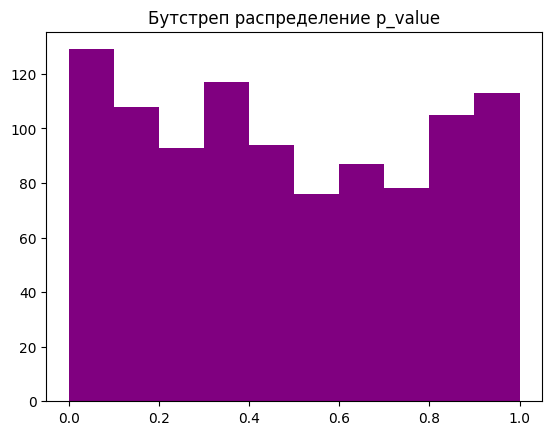

In [54]:
plt.hist(p_values, bins=10, color='purple');
plt.title(f"Бутстреп распределение p_value")

In [55]:
stat, p_value = sts.kstest(p_values, sts.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.0069955902779505075 - p_values неравномерное распределение


#### У нас оказалось неравномерное распределение p-value, так что я решил попробовать другой способ разбиения на выборки

In [80]:
two_week_interactions_copied = two_week_interactions.copy()

In [84]:
correctness = []
values = []

two_week_interactions_copied['user_id'] = two_week_interactions_copied['user_id'].astype(str)
two_week_interactions_copied = two_week_interactions_copied.drop_duplicates()

for i in tqdm(range(1000), position=0, leave=True):  # в дз используем 1000 итераций 
    
    groups = pd.util.hash_pandas_object(two_week_interactions_copied['user_id'] + '#' + salt_generator()) % 2

    vec_a = two_week_interactions_copied[groups == 0]['total_dur']
    vec_b = two_week_interactions_copied[groups == 1]['total_dur']

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)

    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                          [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

    correctness.append(not left_side <= 0 <= right_side)

    test_correctness = collections.Counter(correctness)

print(f'significance: {test_correctness[1] / (test_correctness[1] + test_correctness[0]) * 100}%')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:02:42<00:00, 10.96s/it]

significance: 5.8999999999999995%


На семинаре `significance` был равен 5 (там были взаимодействия за одну неделю)  
У нас же получилось – 5.9

In [88]:
p_values = [get_p_value(dist) for dist in values]

Text(0.5, 1.0, 'Бутстреп распределение p_value')

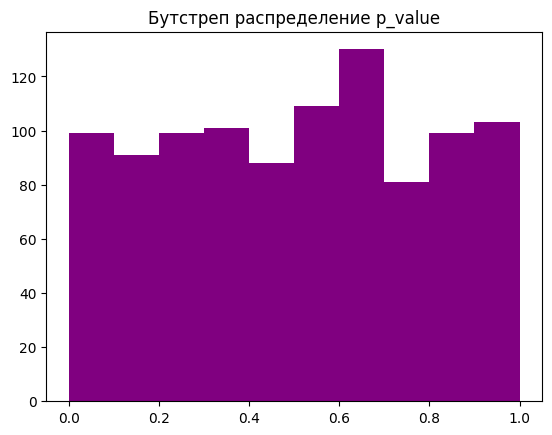

In [89]:
plt.hist(p_values, bins=10, color='purple');
plt.title(f"Бутстреп распределение p_value")

In [87]:
stat, p_value = sts.kstest(p_values, sts.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.6034104769550357 - p_values равномерное распределение


Будем работать с этим

## 3. На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)

In [118]:
from tweedie.tweedie_dist import tweedie_gen

def generate_tweedie(mu, shape, p=1.5, phi=25):
    tw = tweedie_gen()
    return tw(p=p, mu=mu, phi=phi).rvs(shape)

In [122]:
def test_power(df, effect=0, n_iter=1000):
    """
    Функция для расчета мощности с разным эффектом
    """
    correctness = []
    values = []

    for i in tqdm(range(n_iter), position=0, leave=True):

        groups = pd.util.hash_pandas_object(df['user_id'] + '#' + salt_generator()) % 2

        vec_a = df[groups == 0]['total_dur']
        vec_b = df[groups == 1]['total_dur']
        
        vec_b += generate_tweedie(effect * vec_b.mean(), vec_b.shape[0])
        
        sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
        sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)

        values.append(sample_a_mean - sample_b_mean)

        left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                              [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

        correctness.append(not left_side <= 0 <= right_side)

        test_correctness = collections.Counter(correctness)
        
    return {'effect': effect, 
            'correctness': correctness, 
            'values': values, 
            'test_correctness': test_correctness}

In [124]:
power_tests_results = []

for eff in [0.01, 0.03, 0.05]:
    power_tests_results.append(test_power(df=two_week_interactions_copied,
                                          effect=eff,
                                          n_iter=1000))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:44:36<00:00,  6.28s/it]


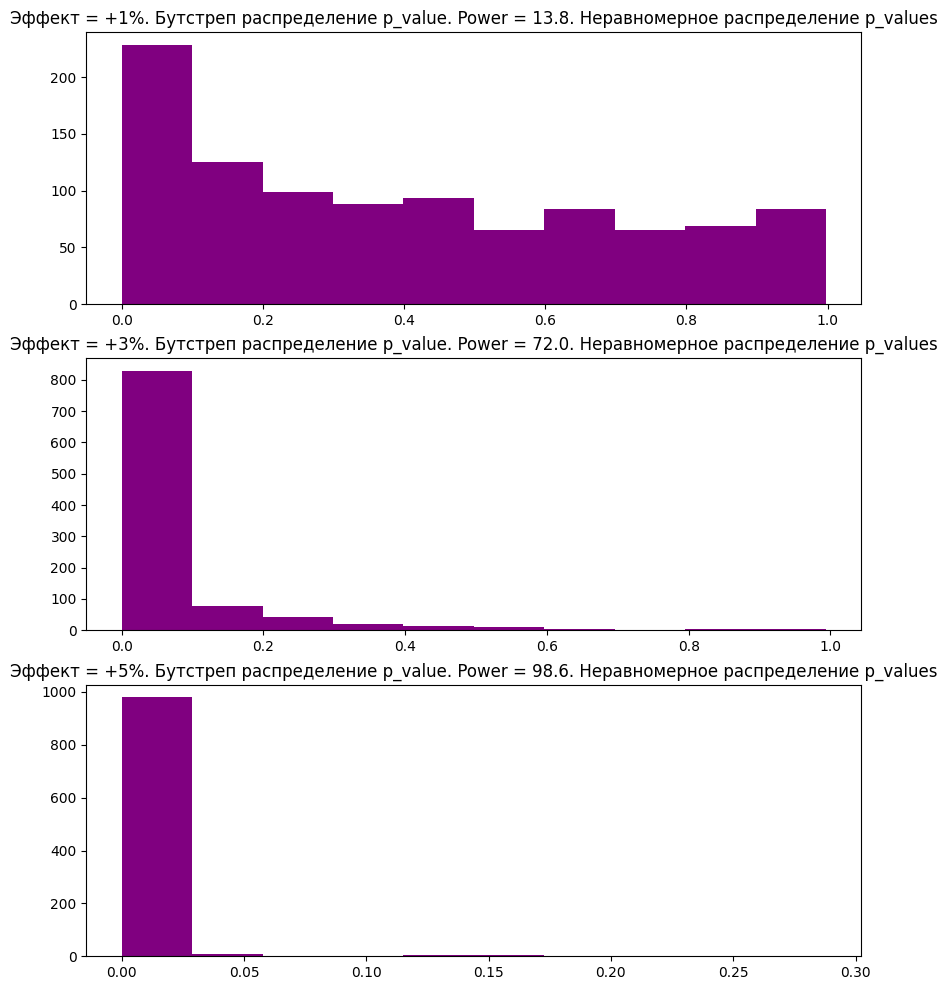

In [141]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

for i, res in enumerate(power_tests_results):
    p_values = np.array([get_p_value(dist) for dist in res['values']])

    stat, p_value = sts.kstest(p_values, sts.uniform(loc=0.0, scale=1.0).cdf)

    beta = (p_values > 0.05).mean()

    if p_value < 0.05:
        uniform_distribution = "Неравномерное распределение p_values"
    else:
        uniform_distribution = "Равномерное распределение p_values"

    axs[i].hist(p_values, bins=10, color='purple');
    axs[i].set_title(f"Эффект = +{round(res['effect']*100)}%. Бутстреп распределение p_value. Power = {round(100*(1 - beta), 1)}. {uniform_distribution}")

## 4. Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)

In [142]:
from scipy.stats import norm

In [143]:
norm.ppf(1-(0.05 / 2), loc=0, scale=1)

1.959963984540054

In [144]:
norm.ppf(1-0.2, loc=0, scale=1)

0.8416212335729143

In [145]:
def get_mde(metric_vec, alpha=0.05, beta=0.2):
    
    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()
    
    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)
    
    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    
    return mde*100/metric_mean

In [146]:
get_mde(two_week_interactions['total_dur'])

1.6447007696706424

# Теперь A/B тест (плак-плак)

## 2. Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

In [154]:
two_week_interactions_ab_test = two_week_interactions.copy()

In [157]:
two_week_interactions_ab_test.loc[two_week_interactions_ab_test['total_dur'] < 500, 'total_dur'] = 0

Проверка

In [170]:
two_week_interactions_ab_test[(two_week_interactions_ab_test['total_dur'] > 0) & 
                              (two_week_interactions_ab_test['total_dur'] < 500)]

,user_id,item_id,last_watch_dt,total_dur,watched_pct


## 3. Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

In [211]:
ab_test_groups = groups_splitter(two_week_interactions_ab_test.copy(), 
                         columns=['user_id', 'total_dur', 'group'], 
                         user_salt='kiontestmodel20210805').drop_duplicates().copy()

In [212]:
headtail(ab_test_groups)

,user_id,total_dur,group
6,1016458,1672,A
9,203219,6975,B
22,505244,15991,A
24,916352,1812,A
30,1057871,5033,A
5476215,204332,822,B
5476222,1007900,0,A
5476246,648596,0,B
5476248,697262,18307,A
5476250,319709,3921,A


## 4. Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)

In [213]:
ab_test_groups.groupby(['group']).agg({'total_dur': ['sum', 'mean']})

total_dur             
              sum         mean
group                         
A      2844750796  7927.232488
B      2818840303  7891.026292

In [214]:
ab_test_groups['total_dur'] = ab_test_groups['total_dur'].astype(float)

Если честно, по описанию не до конца понятно, 10% самых смотрящих пользователей среди всех пользователей или среди пользователей группы B.  Допустим речь идет про топ 10% смотрящих в группе B

In [216]:
ab_test_groups[ab_test_groups['group'] == 'B'].groupby(['user_id']).agg({'total_dur': 'sum'}).reset_index().sort_values(by=['total_dur'], ascending=False).iloc[:13248]

,user_id,total_dur
83717,696597,9731707.0
96499,801503,6975755.0
45616,379372,5263287.0
123129,1019973,4321327.0
111923,927162,4175405.0
...,...,...
92954,772113,46825.0
5319,44274,46815.0
125846,1042266,46803.0
89891,747301,46802.0


90% перцентиль общего просмотра среди пользователей в группе B:

In [217]:
ab_test_groups[ab_test_groups['group'] == 'B'].groupby(['user_id']).agg({'total_dur': 
                                                                         'sum'}).reset_index()['total_dur'].quantile(0.9)

46798.40000000001

In [218]:
top10_min_dur_B = ab_test_groups[ab_test_groups['group'] == 'B'].groupby(['user_id']).agg({'total_dur': 
                                                                                           'sum'}).reset_index()['total_dur'].quantile(0.9)

Топ 10% самых смотрящих пользователей среди группы B:

In [219]:
ab_test_groups[ab_test_groups['group'] == 'B'].groupby(['user_id']).agg({'total_dur': 
                                                                         'sum'}).reset_index().query('total_dur > @top10_min_dur_B')['user_id'].unique()

array([      3,     106,     120, ..., 1097444, 1097459, 1097515])

In [220]:
top10_percent_users_B = ab_test_groups[ab_test_groups['group'] == 'B'].groupby(['user_id']).agg({'total_dur': 
                                                                                                 'sum'}).reset_index().query('total_dur > @top10_min_dur_B')['user_id'].unique()

In [221]:
ab_test_groups.loc[(ab_test_groups['group'] == 'B') & 
                   (ab_test_groups['user_id'].isin(top10_percent_users_B)), 'total_dur'] = ab_test_groups.loc[(ab_test_groups['group'] == 'B') & 
                   (ab_test_groups['user_id'].isin(top10_percent_users_B)), 'total_dur'] * 1.025

Добавили эффект вручную

In [222]:
ab_test_groups.groupby(['group']).agg({'total_dur': ['sum', 'mean']})

total_dur             
                sum         mean
group                           
A      2.844751e+09  7927.232488
B      2.863624e+09  8016.393524

## 5. Посчитайте результат такого теста и сделайте выводы (2 балла)

In [224]:
sample_a_mean = calc_bootstrap_mean(ab_test_groups.loc[ab_test_groups['group'] == 'A']['total_dur'], size=1000)
sample_b_mean = calc_bootstrap_mean(ab_test_groups.loc[ab_test_groups['group'] == 'B']['total_dur'], size=1000)
diff = sample_b_mean - sample_a_mean

left_side, right_side = np.percentile(diff, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
print(left_side, right_side)

-87.56525769840974 275.0196090015386


In [225]:
get_p_value(diff)

0.30000000000000004

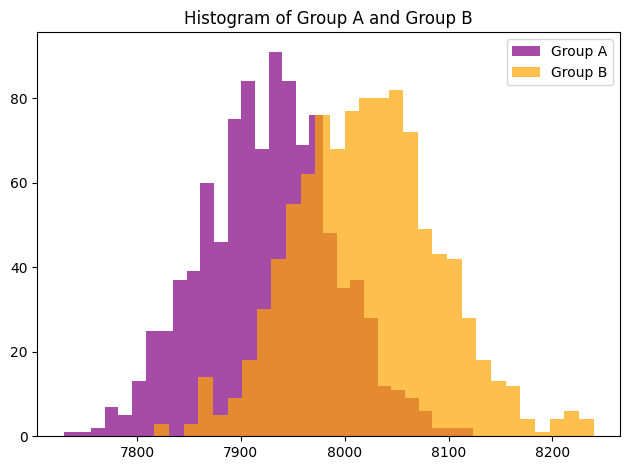

In [230]:
plt.hist(sample_a_mean, 
         bins=30, color='purple', alpha=0.7, label='Group A')
plt.hist(sample_b_mean, 
         bins=30, color='orange', alpha=0.7, label='Group B')
plt.title('Histogram of Group A and Group B')
plt.legend()
plt.tight_layout()
plt.show()

### Выводы
- `p_value` получилось 0.3 (> 0.05) => значит, у нас нет оснований отклонить нулевую гипотезу – гипотезу о том, что между выборками нет статически значимой разницы